# Lesson 4 Assignment

In this lab assignment, you will build a non-tree-based classifier where you can ensemble any base-learners and pass it to the using a BaggingClassifier or any of the other ensemble learners in sklearn.ensemble.

In [66]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# make this notebook's output stable across runs
np.random.seed(0)

## Data Set Information:

This dataset represents a set of possible advertisements on Internet pages. The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occuring near the anchor text. The task is to predict whether an image is an advertisement ("ad") or not ("nonad"). Additional information can be found [here](https://archive.ics.uci.edu/ml/datasets/internet%2Badvertisements).

## Attribute Information:

The dataset has 3 continous (height, width, aratio) and 1555 binary (urls, tags, captions) features.

## Source:

Creator & donor: Nicholas Kushmerick <nick '@' ucd.ie>

In [67]:
# Load the data
internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', on_bad_lines='skip')
print(internetAd.info())
internetAd.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 1559 entries, height to Target
dtypes: int64(1554), object(5)
memory usage: 39.0+ MB
None


<ipython-input-67-28ceae0b03d7>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', on_bad_lines='skip')


,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
5,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
6,59,460,7.7966,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
7,60,234,3.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
8,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
9,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


Question 1: Prepare and impute missing values with the median

In [68]:
import numpy as np

internetAd = internetAd.replace({'nonad.': 0, 'ad.': 1})
#internetAd.head(11)
internetAd = internetAd.replace({'\?': np.NaN}, regex=True)

meds = internetAd.median()
internetAd = internetAd.fillna(meds)
internetAd.isnull().sum()

# This funciton searches the entire dataframe for ANY data equal to the value param
internetAd[internetAd.eq('?').any(axis=1)] # Found 0 rows
internetAd[internetAd.eq('ad.').any(axis=1)] # found 0 rows
internetAd[internetAd.eq('nonad.').any(axis=1)] # found 0 rows

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target


Question 2: Split dataset into training and test set

In [69]:
from sklearn.model_selection import train_test_split

X = internetAd.iloc[:,:-1]
y = internetAd.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



Question 3: Train and evaluate a LogisticRegression classifier using LogisticRegression.

In [70]:
logr = LogisticRegression(max_iter=10000, random_state=42)
logr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [71]:
def auroc_curve(X_test, y_test, y_pred, y_proba):

  # evaluate the model performance - AUC and ROC
  fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1, drop_intermediate=False) #drop_intermediate=False so we get all thresholds
  auc = roc_auc_score(y_test, y_proba)

  # Confusion table
  confusion_mtx = confusion_matrix(y_test, y_pred)
  print(confusion_mtx)
  # Classifier stats
  print(classification_report(y_test, y_pred))

  # Create a ROC curve with the AUC label
  plt.plot(fpr, tpr, label="AUC="+str(auc))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()


[[910   6]
 [ 32 135]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       916
           1       0.96      0.81      0.88       167

    accuracy                           0.96      1083
   macro avg       0.96      0.90      0.93      1083
weighted avg       0.96      0.96      0.96      1083



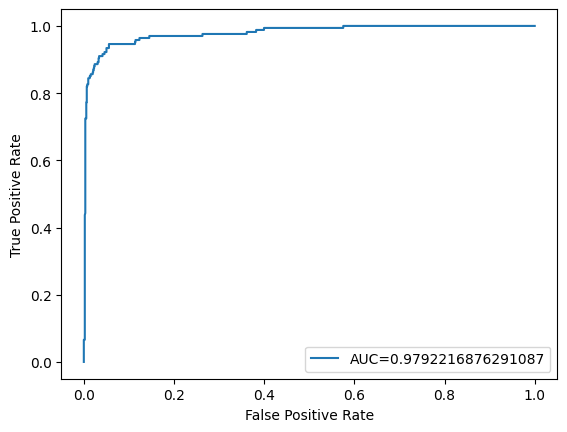

In [72]:
 # make predictions with the trained random forest
test_z = logr.predict(X_test)
test_z_proba = logr.predict_proba(X_test)[::,1]

auroc_curve(X_test, y_test, test_z, test_z_proba)



Question 4: Use BaggingClassifier to train and evaluate an ensemble model of LogisticRegression  base classifiers. Each base classifier should be trained only on a sample half the size of the training data, and using only half as many features as there are in in total the training data (read the documentation for the function to see how to do this).

In [73]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, random_state=42))

bagOLR = BaggingClassifier(base_estimator=pipeline, n_estimators=5, max_features=0.5, max_samples=0.5, bootstrap_features=True)
bagOLR.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('logisticregression',
                                                  LogisticRegression(max_iter=10000,
                                                                     random_state=42))]),
                  bootstrap_features=True, max_features=0.5, max_samples=0.5,
                  n_estimators=5)

[[908   8]
 [ 37 130]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       916
           1       0.94      0.78      0.85       167

    accuracy                           0.96      1083
   macro avg       0.95      0.88      0.91      1083
weighted avg       0.96      0.96      0.96      1083



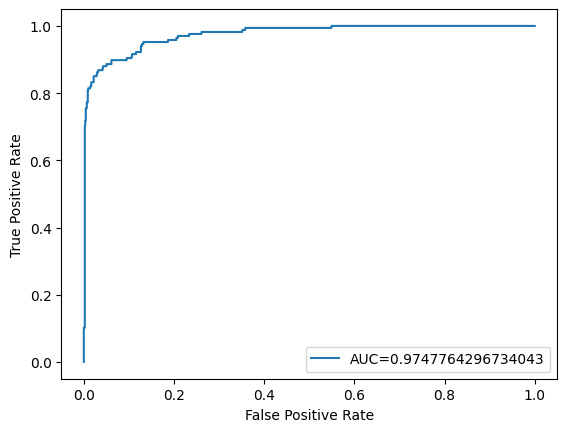

In [74]:
# make predictions with the trained random forest
test_z_bag = bagOLR.predict(X_test)
test_z_bag_proba = bagOLR.predict_proba(X_test)[::,1]

# evaluate the model performance - AUC and ROC
auroc_curve(X_test, y_test, test_z_bag, test_z_bag_proba)

Question 5: Use AdaBoostClassifier to train and evaluate an ensemble model of LogisticRegression base classifiers.

In [75]:
ada_logr = LogisticRegression(max_iter=10000, random_state=42)

boostOkLR = AdaBoostClassifier(estimator=ada_logr, n_estimators=5, learning_rate=1) # Pipeline doesn't support sample_weight in API. # I will just manually create the Logregr
boostOkLR.fit(X_train, y_train)

AdaBoostClassifier(estimator=LogisticRegression(max_iter=10000,
                                                random_state=42),
                   learning_rate=1, n_estimators=5)

[[906  10]
 [ 84  83]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       916
           1       0.89      0.50      0.64       167

    accuracy                           0.91      1083
   macro avg       0.90      0.74      0.79      1083
weighted avg       0.91      0.91      0.90      1083



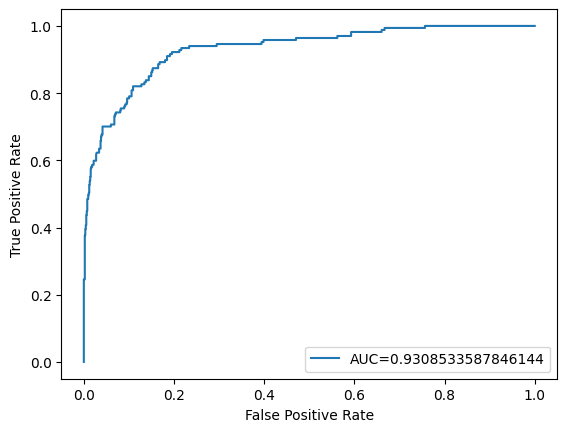

In [76]:
# make predictions with the trained random forest
test_z_abc = boostOkLR.predict(X_test)
test_z_abc_proba = boostOkLR.predict_proba(X_test)[::,1]

# evaluate the model performance - AUC and ROC
auroc_curve(X_test, y_test, test_z_abc, test_z_abc_proba)

[Bonus] Question 6: Use StackingClassifier to train and evaluate an ensemble model of LogisticRegression base classifiers. to get better accuracy than previous classifiers.

[[910   6]
 [ 32 135]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       916
           1       0.96      0.81      0.88       167

    accuracy                           0.96      1083
   macro avg       0.96      0.90      0.93      1083
weighted avg       0.96      0.96      0.96      1083



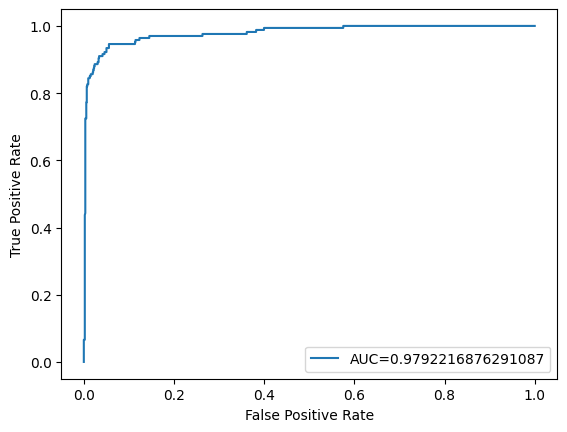

In [78]:
from sklearn.ensemble import StackingClassifier

# We need to define some levels
# We are only doing Logregs so let's define levels of logregs
level0 = list()
level0.append(('lr1', LogisticRegression(max_iter=10000, random_state=42)))
level0.append(('lr2', LogisticRegression(max_iter=10000, random_state=42)))
level0.append(('lr3', LogisticRegression(max_iter=10000, random_state=42)))
level0.append(('lr4', LogisticRegression(max_iter=10000, random_state=42)))
level0.append(('lr5', LogisticRegression(max_iter=10000, random_state=42)))
level1 = LogisticRegression(max_iter=10000, random_state=42)

stck_clf = StackingClassifier(estimators=level0, final_estimator=level1, cv=10)
stck_clf.fit(X_train, y_train)

# make predictions with the trained random forest
test_z_stck = stck_clf.predict(X_test)
test_z_stck_proba = stck_clf.predict_proba(X_test)[::,1]

# evaluate the model performance - AUC and ROC
auroc_curve(X_test, y_test, test_z_stck, test_z_stck_proba)

Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.

# Q.7

1. I did not have any experience with stacking prior to this assignment but I find ensembles are de-facto more useful than single model solutions in the real world.
2. I didn't encounter many obstacles - although I did get confused on the APIs again and feel like I tend to make simple mistakes at times remembering the correct calls. I reused some information on filling the nulls from Lesson 4/6 in ML510. Always helps to have a notebook handy! 😀
3. I could imagine stacking being HUGE for neural network models - being able to combine linear/nonlinear models and aggregate the results is massively useful. Blending as well, although it is less complicated it requires less compute.
4. Some steps that I noticed: pipeline improvement - we filled the values, did some replacement during our modeling (bootstrapping), and we did some scaling (or at least I did in my pipeline), and we even did some CV. I think we covered a good amount here, although how the APIs are written leads to some of these steps being obfuscated at the top level. My biggest problem with all of the Python ML libraries has so far been the way they're written to accomodate legacy workflows from R. Still better than using R in 2024 though.
5. If I set the n_estimators very high on Bagging classifier it outperformed the Stacking, but if I set a comparable number of estimators the Stacking Classsifier slightly outperforms everything. I'm sure if I used more than Logreg I could get really good results with the Stacking classifier.

In [ ]:
%%shell

jupyter nbconvert --to html /content/Lab5.ipynb